In [1]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.color import label2rgb

# Load the JSON file
with open('/Users/pallavisingh/Downloads/combined_annotations.json', 'r') as file:
    data = json.load(file)



In [2]:
# Initialize results
results = []

In [144]:
# # Load the nucleus mask
# nucleus_mask_path = '/Users/pallavisingh/Library/CloudStorage/OneDrive-SharedLibraries-DalhousieUniversity/Priyadharshini Sridharan - Images from Dellaire Lab/input/binary_mask_nucleus_non_arsenic/flattened_position_17-1_C0_mask.tif'
# nucleus_mask = cv2.imread(nucleus_mask_path, cv2.IMREAD_GRAYSCALE)
# if nucleus_mask is None:
#     print(f"Error loading mask for {image_name}. Skipping.")
    

# MIN_NUCLEUS_AREA = 50  # Adjust this threshold as needed based on your data

# # Label individual nuclei
# labeled_mask = label(nucleus_mask > 0)
# nuclei_props = [prop for prop in regionprops(labeled_mask) if prop.area >= MIN_NUCLEUS_AREA]

# # Create a mapping for nucleus names
# nucleus_name_map = {prop.label: f"Nucleus {i+1}" for i, prop in enumerate(nuclei_props)}

# # Relabel the mask with only valid nuclei
# filtered_mask = np.zeros_like(labeled_mask)
# for prop in nuclei_props:
#     filtered_mask[labeled_mask == prop.label] = prop.label

# # Initialize data structures for density calculations
# nucleus_dot_counts = {prop.label: 0 for prop in nuclei_props}
# nucleus_areas = {prop.label: prop.area for prop in nuclei_props}

In [145]:
# # Create a labeled RGB mask for visualization
# labeled_rgb_mask = label2rgb(labeled_mask, bg_label=0)

# # Visualize the labeled nuclei and overlay dots
# plt.figure(figsize=(12, 8))

# # Plot labeled mask
# plt.subplot(1, 2, 1)
# plt.title("Labeled Nucleus Mask")
# plt.imshow(labeled_rgb_mask)
# plt.axis("off")


# # Show the plot
# plt.tight_layout()
# plt.show()

In [3]:
MIN_NUCLEUS_AREA = 50

In [4]:
# Process each image entry in the JSON file
for entry in data:
    image_name = entry["image_name"]
    image_label = entry["label"]  # Renamed to avoid conflict
    nucleus_mask_path = entry["nucleus_mask"]
    dots = entry["dots"]
    
    # Load the nucleus mask
    nucleus_mask = cv2.imread(nucleus_mask_path, cv2.IMREAD_GRAYSCALE)
    if nucleus_mask is None:
        print(f"Error loading mask for {image_name}. Skipping.")
        continue
    
    # Label individual nuclei
    labeled_mask = label(nucleus_mask > 0)
    nuclei_props = [prop for prop in regionprops(labeled_mask) if prop.area >= MIN_NUCLEUS_AREA]
    
    # Create a mapping for nucleus names
    nucleus_name_map = {prop.label: f"Nucleus {i+1}" for i, prop in enumerate(nuclei_props)}
    
    # Relabel the mask with only valid nuclei
    filtered_mask = np.zeros_like(labeled_mask)
    for prop in nuclei_props:
        filtered_mask[labeled_mask == prop.label] = prop.label
    
    # Initialize data structures for density calculations
    nucleus_dot_counts = {prop.label: 0 for prop in nuclei_props}
    nucleus_areas = {prop.label: prop.area for prop in nuclei_props}
    outside_dot_count =0
    
    # Assign dots to nuclei
    for dot in dots:
        x, y = dot["position"]["x"], dot["position"]["y"]
        nucleus_label = filtered_mask[y, x]
        if nucleus_label > 0:  # Dot is inside a nucleus
            nucleus_dot_counts[nucleus_label] += 1
        else:
            outside_dot_count += 1
    
    # Calculate density for each nucleus and append results
    for nucleus_label, dot_count in nucleus_dot_counts.items():
        nucleus_name = nucleus_name_map[nucleus_label]
        area = nucleus_areas[nucleus_label]
        density = dot_count / area if area > 0 else 0
        results.append({
            "Image_name": image_name,
            "Label": image_label,
            "Nucleus_name": nucleus_name,
            "Count_of_pml_bodies_inside": dot_count,
            "Count_of_pml_bodies_outside": outside_dot_count,
            "Area_of_nucleus": area,
            "Density": density
        })



# print(f"Results saved to {output_file_path}")
# Save results to a CSV file


In [5]:
import pandas as pd
output_file_path = "/Users/pallavisingh/Documents/test/nucleus_density_results_v2.csv"
results_df = pd.DataFrame(results)
# results_df.to_csv(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /Users/pallavisingh/Documents/test/nucleus_density_results_v2.csv


In [6]:
from scipy import stats
# Assuming results_df contains your results
# Filter the data into arsenic-treated and non-arsenic-treated groups

results_df = results_df[results_df['Density'] != 0]
results_df['Density'] = results_df['Density'] * 100

# Split the data into arsenic and non-arsenic groups based on the new log-transformed density
arsenic_group = results_df[results_df['Label'] == 'arsenic']
non_arsenic_group = results_df[results_df['Label'] == 'not arsenic']

# Compute mean and variance of log-transformed densities
arsenic_mean_log_density = arsenic_group['Density'].mean()
arsenic_variance_log_density = arsenic_group['Density'].var()

non_arsenic_mean_log_density = non_arsenic_group['Density'].mean()
non_arsenic_variance_log_density = non_arsenic_group['Density'].var()

# Print the statistics
print(f"Arsenic-treated group: Mean Exponential_Density = {arsenic_mean_log_density}, Variance = {arsenic_variance_log_density}")
print(f"Non-arsenic-treated group: Mean Exponential_Density = {non_arsenic_mean_log_density}, Variance = {non_arsenic_variance_log_density}")

# Hypothesis Testing (log-transformed densities)
t_stat, p_value = stats.ttest_ind(arsenic_group['Density'], non_arsenic_group['Density'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference in log-transformed densities between arsenic-treated and non-arsenic-treated groups.")
else:
    print("There is no significant difference in log-transformed densities between arsenic-treated and non-arsenic-treated groups.")


Arsenic-treated group: Mean Exponential_Density = 0.2880955336230997, Variance = 0.039601871628059074
Non-arsenic-treated group: Mean Exponential_Density = 0.46059049067472047, Variance = 0.03048753420891998
T-statistic: -15.69480457199833, P-value: 1.744828909400786e-50
There is a significant difference in log-transformed densities between arsenic-treated and non-arsenic-treated groups.


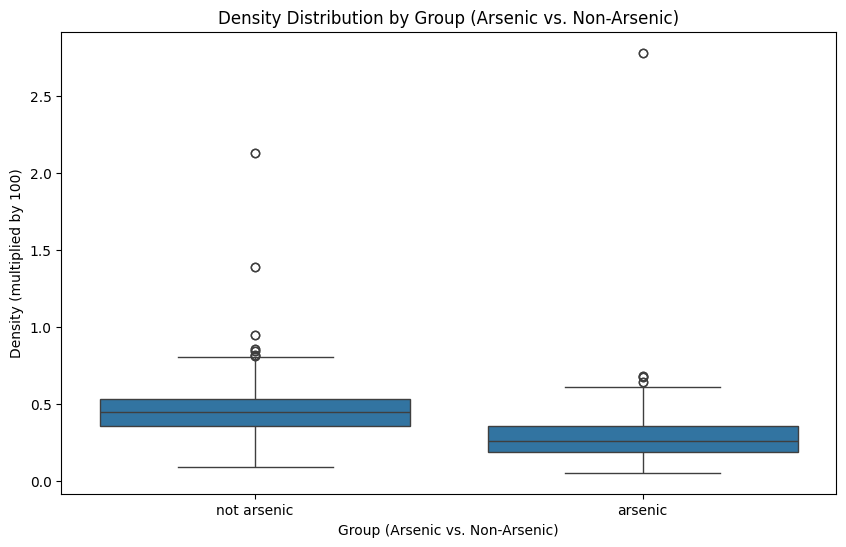

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot to visualize density distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Density', data=results_df)
plt.title('Density Distribution by Group (Arsenic vs. Non-Arsenic)')
plt.ylabel('Density (multiplied by 100)')
plt.xlabel('Group (Arsenic vs. Non-Arsenic)')
plt.show()


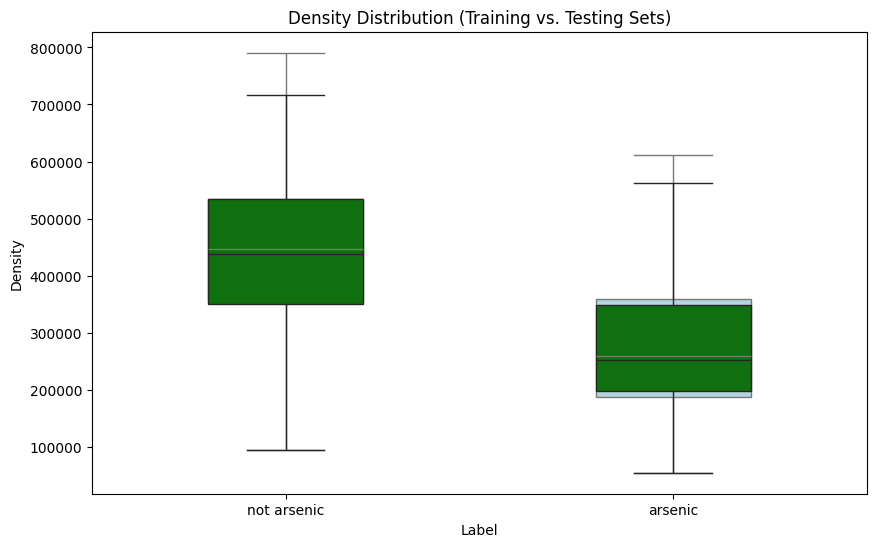

In [33]:
from sklearn.model_selection import train_test_split

# Assuming 'results_df' contains the density data
# Split the data into training and testing sets (80% training, 20% testing)
train_data, test_data = train_test_split(results_df, test_size=0.2, random_state=42)

# Recalculate density on training and testing sets (if needed for validation)
# Here, you can compare the density distributions or calculate statistics for training and testing sets
train_density = train_data['Density']
test_density = test_data['Density']

# For example, plot the density distribution for both training and testing sets
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Density', data=train_data, color='lightblue', showfliers=False, width=0.4)
sns.boxplot(x='Label', y='Density', data=test_data, color='green', showfliers=False, width=0.4)
plt.title('Density Distribution (Training vs. Testing Sets)')
plt.show()


In [34]:
import numpy as np

# Function to calculate mean density from a sample
def calculate_mean_density(sample):
    return np.mean(sample)

# Bootstrapping to estimate confidence intervals
bootstrapped_means = []
n_iterations = 1000
sample_size = len(results_df)

# Resample with replacement and calculate the mean for each bootstrap sample
for _ in range(n_iterations):
    bootstrap_sample = np.random.choice(results_df['Density'], size=sample_size, replace=True)
    bootstrapped_means.append(calculate_mean_density(bootstrap_sample))

# Calculate the 95% confidence interval for the mean
confidence_interval = np.percentile(bootstrapped_means, [2.5, 97.5])
print(f"Bootstrapped 95% Confidence Interval for Density: {confidence_interval}")


Bootstrapped 95% Confidence Interval for Density: [375061.90302504 398532.40809797]


In [8]:
# # Load the JSON file
# with open('/Users/pallavisingh/Downloads/test.json', 'r') as file:
#     data = json.load(file)
    
# results = []

In [9]:
# import cv2
# import numpy as np
# from skimage.measure import label, regionprops
# MIN_NUCLEUS_AREA = 50
# # Process each image entry in the JSON file
# for entry in data:
#     image_name = entry["image_name"]
#     image_label = entry["label"]  # Renamed to avoid conflict
#     nucleus_mask_path = entry["nucleus_mask"]
#     dots = entry["dots"]
    
#     # Load the nucleus mask
#     nucleus_mask = cv2.imread(nucleus_mask_path, cv2.IMREAD_GRAYSCALE)
#     if nucleus_mask is None:
#         print(f"Error loading mask for {image_name}. Skipping.")
#         continue
    
#     # Label individual nuclei
#     labeled_mask = label(nucleus_mask > 0)
#     nuclei_props = [prop for prop in regionprops(labeled_mask) if prop.area >= MIN_NUCLEUS_AREA]
    
#     # Create a mapping for nucleus names
#     nucleus_name_map = {prop.label: f"Nucleus {i+1}" for i, prop in enumerate(nuclei_props)}
    
#     # Relabel the mask with only valid nuclei
#     filtered_mask = np.zeros_like(labeled_mask)
#     for prop in nuclei_props:
#         filtered_mask[labeled_mask == prop.label] = prop.label
    
#     # Initialize data structures for density calculations
#     nucleus_dot_counts = {prop.label: 0 for prop in nuclei_props}
#     nucleus_areas = {prop.label: prop.area for prop in nuclei_props}
#     outside_dot_count = 0  # Counter for dots outside of nuclei
    
#     # Create a colored image for highlighting the dots
#     labeled_image = cv2.cvtColor(nucleus_mask, cv2.COLOR_GRAY2BGR)  # Convert to BGR for color highlighting
    
#     # Assign dots to nuclei and count outside dots
#     for dot in dots:
#         x, y = dot["position"]["x"], dot["position"]["y"]
#         nucleus_label = filtered_mask[y, x]
        
#         # Highlight the dot on the labeled image (in red color)
#         if nucleus_label > 0:  # Dot is inside a nucleus
#             nucleus_dot_counts[nucleus_label] += 1
#             cv2.circle(labeled_image, (x, y), 5, (0, 0, 255), -1)  # Red color for inside dots
#         else:  # Dot is outside of all nuclei
#             outside_dot_count += 1
#             cv2.circle(labeled_image, (x, y), 5, (255, 0, 0), -1)  # Blue color for outside dots
    
#     # Calculate density for each nucleus and append results
#     for nucleus_label, dot_count in nucleus_dot_counts.items():
#         nucleus_name = nucleus_name_map[nucleus_label]
#         area = nucleus_areas[nucleus_label]
#         density = dot_count / area if area > 0 else 0
#         results.append({
#             "Image_name": image_name,
#             "Label": image_label,
#             "Nucleus_name": nucleus_name,
#             "Count_of_pml_bodies_inside": dot_count,
#             "Area_of_nucleus": area,
#             "Density": density,
#             "Count_of_pml_bodies_outside": outside_dot_count  # Add the outside count
#         })
    
#     # Save the labeled image with dots highlighted
#     output_image_path = f"/Users/pallavisingh/Documents/test/highlighted_{image_name}.png"
#     cv2.imwrite(output_image_path, labeled_image)
#     print(f"Highlighted image saved to {output_image_path}")




Highlighted image saved to /Users/pallavisingh/Documents/test/highlighted_flattened_position_8-1_C1.png


In [37]:
results = []
MIN_NUCLEUS_AREA = 50
# Process each image entry
for entry in data:
    image_name = entry["image_name"]
    image_label = entry["label"]
    nucleus_mask_path = entry["nucleus_mask"]
    dots = entry["dots"]
   

    # Load the nucleus mask
    nucleus_mask = cv2.imread(nucleus_mask_path, cv2.IMREAD_GRAYSCALE)
    if nucleus_mask is None:
        print(f"Error loading mask for {image_name}. Skipping.")
        continue

    # Label individual nuclei
    labeled_mask = label(nucleus_mask > 0)
    nuclei_props = [prop for prop in regionprops(labeled_mask) if prop.area >= MIN_NUCLEUS_AREA]
    
    # Create a mapping for nucleus names
    nucleus_name_map = {prop.label: f"Nucleus {i+1}" for i, prop in enumerate(nuclei_props)}
    
    # Relabel the mask with only valid nuclei
    filtered_mask = np.zeros_like(labeled_mask)
    for prop in nuclei_props:
        filtered_mask[labeled_mask == prop.label] = prop.label
    
    # Initialize data structures for density calculations
    nucleus_dot_counts = {prop.label: 0 for prop in nuclei_props}
    nucleus_areas = {prop.label: prop.area for prop in nuclei_props}
    nucleus_pml_area = {prop.label: 0 for prop in nuclei_props}  # Store PML area for each nucleus
    nucleus_pml_body_areas = {prop.label: [] for prop in nuclei_props}  # Store list of PML body areas for each nucleus

    # Assign dots to nuclei and calculate total PML area for each nucleus
    for dot in dots:
        x, y = dot["position"]["x"], dot["position"]["y"]
        nucleus_label = filtered_mask[y, x]
        if nucleus_label > 0:  # Dot is inside a nucleus
            nucleus_dot_counts[nucleus_label] += 1
            nucleus_pml_area[nucleus_label] += dot["area"]  # Add dot's PML area to the nucleus
            nucleus_pml_body_areas[nucleus_label].append(dot["area"])  # Add PML area of each dot

    # Calculate density and average PML area and append results
    for nucleus_label, dot_count in nucleus_dot_counts.items():
        nucleus_name = nucleus_name_map[nucleus_label]
        area = nucleus_areas[nucleus_label]
        pml_area = nucleus_pml_area[nucleus_label]  # Get total PML body area for this nucleus
        pml_body_areas = nucleus_pml_body_areas[nucleus_label]  # Get list of PML body areas for this nucleus
        
        # Calculate average PML area (avoid division by zero)
        avg_pml_area = sum(pml_body_areas) / len(pml_body_areas) if len(pml_body_areas) > 0 else 0
        
        density = dot_count / area if area > 0 else 0
        results.append({
            "Image_name": image_name,
            "Label": image_label,
            "Nucleus_name": nucleus_name,
            "Count_of_pml_bodies_inside": dot_count,
            "Area_of_nucleus": area,
            "PML_area_inside": pml_area,
            "Avg_PML_area_inside": avg_pml_area,  # Store average PML area
            "Density": density
        })

In [45]:
output_file_path = "/Users/pallavisingh/Documents/test/nucleus_density_results_v1.csv"
results_df = pd.DataFrame(results)
# results_df.to_csv(output_file_path, index=False)

print(f"Results saved to {output_file_path}")

Results saved to /Users/pallavisingh/Documents/test/nucleus_density_results_v1.csv


In [43]:
results_df

,Image_name,Label,Nucleus_name,Count_of_pml_bodies_inside,Area_of_nucleus,PML_area_inside,Avg_PML_area_inside,Density
0,flattened_position_40-1_C1,not arsenic,Nucleus 1,1,400.0,1,1.000000,0.002500
1,flattened_position_40-1_C1,not arsenic,Nucleus 2,13,3291.0,94,7.230769,0.003950
2,flattened_position_40-1_C1,not arsenic,Nucleus 3,11,2798.0,184,16.727273,0.003931
3,flattened_position_40-1_C1,not arsenic,Nucleus 4,15,2842.0,74,4.933333,0.005278
4,flattened_position_40-1_C1,not arsenic,Nucleus 5,8,2350.0,18,2.250000,0.003404
...,...,...,...,...,...,...,...,...
1205,flattened_position_31_C1,arsenic,Nucleus 4,12,3152.0,4,0.333333,0.003807
1206,flattened_position_31_C1,arsenic,Nucleus 5,9,3220.0,12,1.333333,0.002795
1207,flattened_position_31_C1,arsenic,Nucleus 6,8,3601.0,13,1.625000,0.002222
1208,flattened_position_31_C1,arsenic,Nucleus 7,16,3718.0,30,1.875000,0.004303
